## Comparaison des distances sur des simulations de modèles de ressorts perturbés

Chaque jeu de simulation a été simulé pour des paramètres `(F, k)` fixés. Le bruit et les conditions intiales sont aléatoires et varient selon chaque simulation.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import time
import pandas as pd
from tqdm import tqdm
import pickle
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler 

from descriptor import compute_descriptor
from wasserstein_distance import compute_wasserstein_distance
from kolmogorov_distance import compute_kolmogorov_dist
from data_functions import load_data, plot_data
import simu_ressort

In [2]:
weights = [0., 0.0425034, 0.02624669, 0.30339451, 0.16850823, 0.23280556, 0.14751689, 0.07902472]
names_desc = ['mean', 'std', 'fr_max', 'ampl_max', 'spectral centroid',
              'spectral width', 'spectral platitude', 'spectral asymetry']

# Check que la somme fait bien 1
print(np.sum(weights))

1.0


### Load data

In [4]:
all_simus = simu_ressort.load_obj("./data/ressort/simus.pkl")

print("{} parameters tested, and {} simus for each parameter.".format(len(all_simus),
                                                                      all_simus[0]['N']))
print("The duration of each simu is {} dt.".format(np.shape(all_simus[0]['simu'])[1]))

# Normalize data
for j in range(len(all_simus)):
    for i in range(len(all_simus[j]['simu'])):
        all_simus[j]['simu'][i, :] = preprocessing.scale(all_simus[j]['simu'][i, :])

81 parameters tested, and 200 simus for each parameter.
The duration of each simu is 1000 dt.


`all_simu` contient les simulations, chaque élément contient les paramètres et toutes les simulations effectuées avec ces paramètres dans l'item `simu`

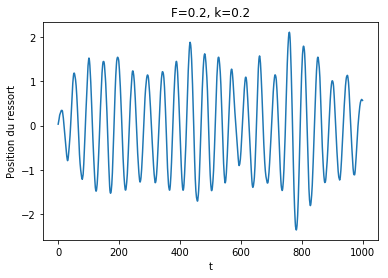

In [5]:
# Exemple
i, j = 10, 10
simu_ressort.plot_ressort(all_simus[i]['simu'][j, :], F=all_simus[i]['F'], k=all_simus[i]['k'])

#### Mettre sous la forme DataFrame comme les simus de poumons
Format qu'il faudrait que l'on change parce qu'il est pas ouf mais bon...

In [6]:
sets = simu_ressort.transform_simus_to_df(all_simus, nmax=200)

100%|█████████████████████████████████████████████████████████████████████████████████| 81/81 [00:00<00:00, 374.92it/s]


In [7]:
def plot_df(df, nmax=None, long=None):
    if not nmax:
        nmax = df.shape[1]
    if not long:
        long = df.shape[0]
    for col in df.columns[:nmax]:
        df[col].plot()
    plt.show()

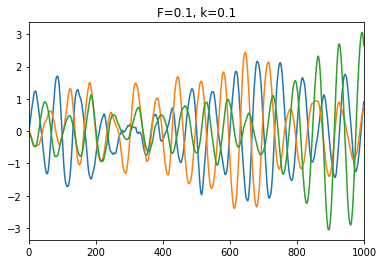

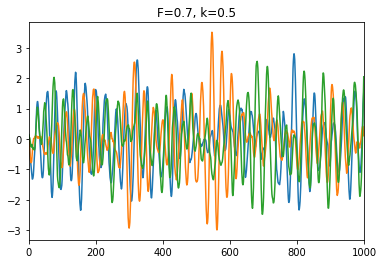

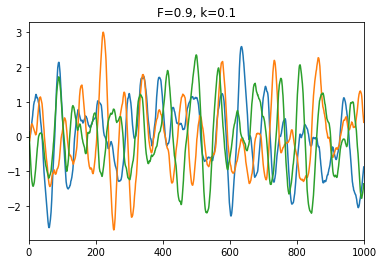

In [8]:
# Exemples de simus
nmax = 3
long = 500

i = 0
plt.title("F={}, k={}".format(all_simus[i]['F'],all_simus[0]['k']))
plot_df(sets[i], nmax, long)

i = 42
plt.title("F={}, k={}".format(all_simus[i]['F'], all_simus[i]['k']))
plot_df(sets[i], nmax, long)

i = 8
plt.title("F={}, k={}".format(all_simus[i]['F'], all_simus[i]['k']))
plot_df(sets[i], nmax, long)

## Tests avec les poids

In [9]:
compute_kolmogorov_dist(sets[0], sets[32], weights=weights)

D:\Cours\Ponts\MVA\ACTERREA\Code\acterrea\descriptor.py:8: RuntimeWarning: invalid value encountered in double_scalars
  sm = np.sum(fft*(freq**i))/np.sum(fft)


0.99833996799370606

In [10]:
start_time = time.time()
d = compute_wasserstein_distance(sets[0], sets[32], weights=weights)
print("Execution time: {} min".format(round((time.time() - start_time) / 60, 2)))
print("Distance:", d)

D:\Cours\Ponts\MVA\ACTERREA\Code\acterrea\descriptor.py:8: RuntimeWarning: invalid value encountered in double_scalars
  sm = np.sum(fft*(freq**i))/np.sum(fft)


KeyboardInterrupt: 

### Calculer les distances entre chaque couple de simus

In [11]:
def compute_dist_sets(sets, weights, name):
    distances = []
    params = []
    
    for data1 in tqdm(sets):
    #for df1 in [sets[42]]:
        for data2 in tqdm(sets):
            kolm_dist = compute_kolmogorov_dist(data1['data'], data2['data'], weights=weights)
            wasser_dist = compute_wasserstein_distance(data1['data'], data2['data'], weights=weights)
            distances.append([kolm_dist, wasser_dist])
            params.append([data1['F'], data2['F'], data1['k'], data2['k']])
            
        # Re enregistre à chaque fois au cas ou ca plante
        simu_ressort.save_obj(distances, './data/ressort/distances_' + name + '.pkl')
        simu_ressort.save_obj(params, './data/ressort/params_' + name + '.pkl')
            
    return np.array(distances), np.array(params)

**Selectionner que qq jeux de param sinon trop long**

In [12]:
# Sets = liste de dataFrames


def transform_to_df(data, nmax=None):
    df = pd.DataFrame(data)
    df.columns = ['V' + str(i) for i in range(data.shape[1])]
    df = df[['V' + str(i) for i in range(nmax)]]
    return df

sets = []

for i in range(len(all_simus)):
    sets.append({
        'data': transform_to_df(all_simus[i]['simu'].T, nmax=100),
        'F': all_simus[i]['F'],
        'k': all_simus[i]['k']
    })

In [13]:
list_k = [0.2, 0.5, 0.8]
list_F = [0.2, 0.4, 0.6, 0.8]

sets_12 = [item for item in sets if item['F'] in list_F and item['k'] in list_k]  
print(len(sets_12))

name = '12'
distances, params = compute_dist_sets(sets_12, weights, name)

12


  0%|                                                                                           | 0/12 [00:00<?, ?it/s]D:\Cours\Ponts\MVA\ACTERREA\Code\acterrea\descriptor.py:8: RuntimeWarning: invalid value encountered in double_scalars
  sm = np.sum(fft*(freq**i))/np.sum(fft)

 50%|█████████████████████████████████████████▌                                         | 6/12 [01:37<01:37, 16.19s/it]


100%|█████████████████████████████████████████████████████████████████████████████████| 12/12 [58:41<00:00, 293.47s/it]


In [54]:
# Les charger:
name = '12'
distances = simu_ressort.load_obj('./data/ressort/distances_' + name + '.pkl')
params = simu_ressort.load_obj('./data/ressort/params_' + name + '.pkl')

distances = np.array(distances)
params = np.array(params)

print(len(distances))

144


## Affichage

In [55]:
params = [params[i] for i in range(len(params)) if distances[i, 1] != 0]
params = np.array(params)

distances = [x for x in distances if x[1] != 0]
distances = np.array(distances)

len(distances)

132

In [56]:
distances_sc = np.zeros(distances.shape)

distances_sc[:, 0] = np.array(distances[:, 0])
distances_sc[:, 0] -= np.min(distances_sc[:, 0])
distances_sc[:, 0] /= np.max(distances_sc[:, 0])

distances_sc[:, 1] = np.array(distances[:, 1])
distances_sc[:, 1] -= np.min(distances_sc[:, 1])
distances_sc[:, 1] /= np.max(distances_sc[:, 1])

In [57]:
def plot_comparaison(distances):
    plt.scatter(distances[:, 0], distances[:, 1], marker='x')
    plt.xlabel("Distance de Kolmogorov")
    plt.ylabel("Distance de Wasserstein")
    plt.title("Comparaison des distances")
    plt.show()

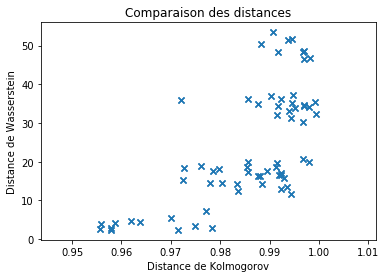

In [58]:
plot_comparaison(distances)

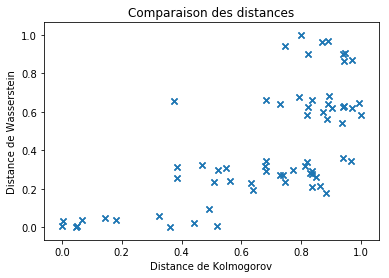

In [59]:
plot_comparaison(distances_sc)

In [60]:
np.corrcoef(distances_sc[:, 0], distances_sc[:, 1])

array([[ 1.        ,  0.67737707],
       [ 0.67737707,  1.        ]])

 -> **Kolmogorov à tester en log**

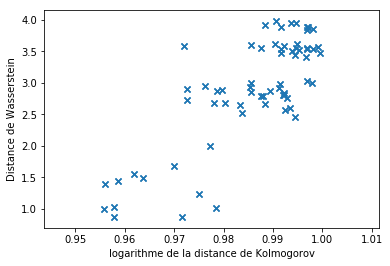

In [61]:
plt.scatter(distances[:, 0], [np.log(x) for x in distances[:, 1]], marker='x')
plt.xlabel('logarithme de la distance de Kolmogorov')
plt.ylabel("Distance de Wasserstein")
plt.show()

In [62]:
distance_by_F = {}

for i in range(len(params)):
    dist_F = abs(params[i, 0] - params[i, 1])
    if dist_F not in distance_by_F:
        distance_by_F[dist_F] = []
    distance_by_F[dist_F].append(distances_sc[i, :])

distance_by_F_moy_kolm = {key: np.mean(np.array(val)[:, 0]) for key, val in distance_by_F.items()}
distance_by_F_moy_wasser = {key: np.mean(np.array(val)[:, 1]) for key, val in distance_by_F.items()}

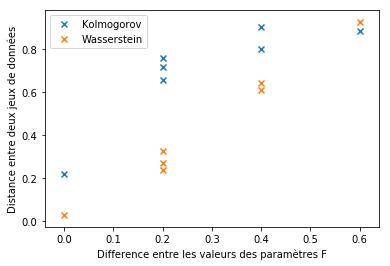

In [65]:
plt.scatter(distance_by_F_moy_kolm.keys(), distance_by_F_moy_kolm.values(), marker='x', label='Kolmogorov')
plt.scatter(distance_by_F_moy_wasser.keys(), distance_by_F_moy_wasser.values(), marker='x', label='Wasserstein')
plt.legend()
plt.xlabel("Difference entre les valeurs des paramètres F")
plt.ylabel("Distance entre deux jeux de données")
plt.show()